In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from deepjets import learning, models, preprocessing, utils

Using Theano backend.


//anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
# Predict probabilities from network (time consuming step)
def get_Y_prob(model, test_h5_file):
    with h5py.File(test_h5_file, 'r') as h5file:
        Y_test = h5file['Y_test'][:]
        Y_prob = model.predict_proba(h5file['X_test'], batch_size=32)
        Y_prob /= Y_prob.sum(axis=1)[:, np.newaxis]
        return Y_test, Y_prob[:, 0]


def plot_dist_file(test_h5_file, var_name, var_label=None, bins=20, loc=1):
    with h5py.File(test_h5_file, 'r') as h5file:
        Y_test = h5file['Y_test'][:]
        var = h5file[var_name][:]
    var_s = var[Y_test[:, 0] == 1]
    var_b = var[Y_test[:, 0] == 0]
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111)
    ax.hist(var_s, bins=bins, histtype='stepfilled', normed=True, color='b', alpha=0.5,
            label='signal')
    ax.hist(var_b, bins=bins, histtype='stepfilled', normed=True, color='r', alpha=0.5,
            label='background')
    if var_label is not None:
        ax.set_xlabel(var_label, fontsize=16)
    else:
        ax.set_xlabel(var_name, fontsize=16)
    ax.set_ylabel("frequency", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.legend(fontsize=16, loc=loc)
    fig.show()


def plot_dist(Y_test, var, var_label=None, bins=20, loc=1):
    var_s = var[Y_test[:, 0] == 1]
    var_b = var[Y_test[:, 0] == 0]
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111)
    ax.hist(var_s, bins=bins, histtype='stepfilled', normed=True, color='b', alpha=0.5,
            label='signal')
    ax.hist(var_b, bins=bins, histtype='stepfilled', normed=True, color='r', alpha=0.5,
            label='background')
    if var_label is not None:
        ax.set_xlabel(var_label, fontsize=16)
    ax.set_ylabel("frequency", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.legend(fontsize=16, loc=loc)
    fig.show()

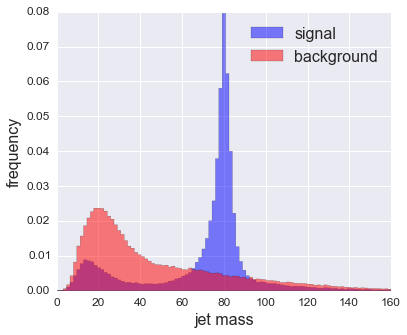

In [21]:
plot_dist_file('datasets/w_test.h5', var_name='mass', var_label="jet mass",
               bins=np.linspace(0, 160, 100))

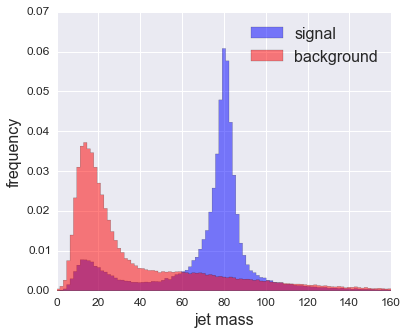

In [5]:
plot_dist_file('datasets/herwig_ang_test.h5', var_name='mass_trimmed_test',
               var_label="jet mass", bins=np.linspace(0, 160, 100))

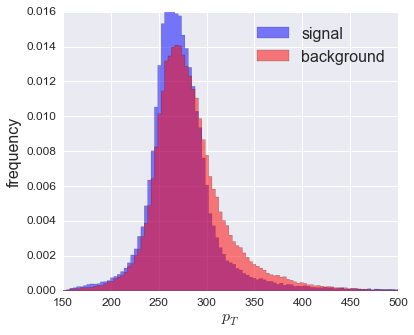

In [6]:
plot_dist_file('datasets/w_test.h5', var_name='pT', var_label=r"$p_T$",
               bins=np.linspace(150, 500, 100))

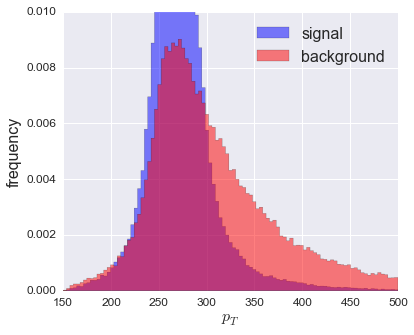

In [7]:
plot_dist_file('datasets/herwig_ang_test.h5', var_name='pt_trimmed_test', var_label=r"$p_T$",
               bins=np.linspace(150, 500, 100))

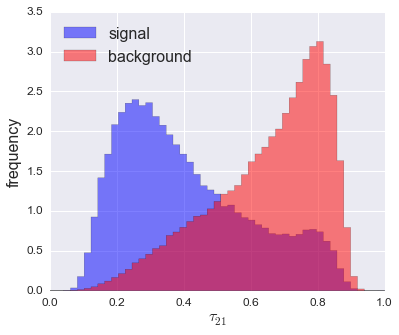

In [8]:
plot_dist_file('datasets/w_test.h5', var_name='tau_21', var_label=r"$\tau_{21}$",
               bins=np.linspace(0, 1, 50), loc=2)

In [9]:
Y_test_shrink, Y_prob_shrink = get_Y_prob(models.load_model('models/maxout_w_default'),
                                          'datasets/w_test.h5')

200000/200000 [==============================] - 34s    


In [10]:
Y_test_noshrink, Y_prob_noshrink = get_Y_prob(models.load_model('models/maxout_w_noshrink'),
                                              'datasets/w_noshrink_test.h5')

200000/200000 [==============================] - 33s    


In [22]:
Y_test_ha, Y_prob_ha = get_Y_prob(models.load_model('models/maxout_w_default'),
                                  'datasets/herwig_ang_test.h5')

193606/193606 [==============================] - 35s    


In [23]:
Y_test_hd, Y_prob_hd = get_Y_prob(models.load_model('models/maxout_w_default'),
                                  'datasets/herwig_dip_test.h5')

193884/193884 [==============================] - 33s    


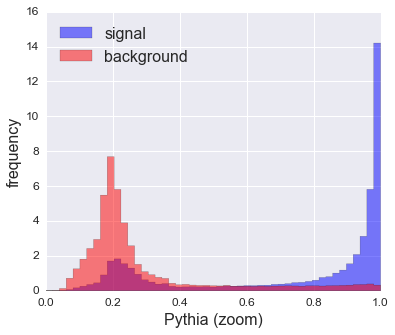

In [24]:
plot_dist(Y_test_shrink, Y_prob_shrink, var_label="Pythia (zoom)",
          bins=np.linspace(0, 1 , 50), loc=2)

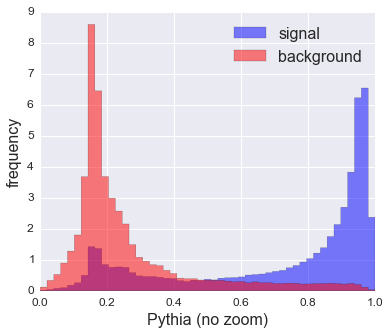

In [34]:
plot_dist(Y_test_noshrink, Y_prob_noshrink, var_label="Pythia (no zoom)",
          bins=np.linspace(0, 1 , 50), loc=1)

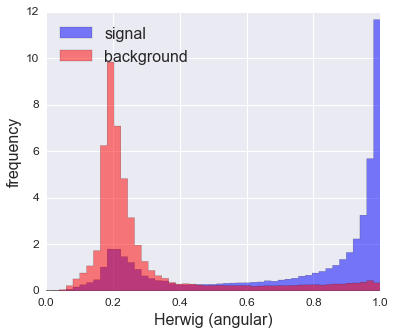

In [26]:
plot_dist(Y_test_ha, Y_prob_ha, var_label="Herwig (angular)",
          bins=np.linspace(0, 1 , 50), loc=2)

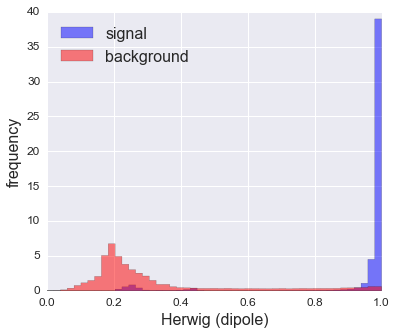

In [27]:
plot_dist(Y_test_hd, Y_prob_hd, var_label="Herwig (dipole)",
          bins=np.linspace(0, 1 , 50), loc=2)

In [41]:
roc_shrink = utils.default_roc_curve(Y_test_shrink, Y_prob_shrink)
roc_noshrink = utils.default_roc_curve(Y_test_noshrink, Y_prob_noshrink)
roc_ha = utils.default_roc_curve(Y_test_ha, Y_prob_ha)
roc_hd = utils.default_roc_curve(Y_test_hd, Y_prob_hd)
roc_mass = utils.auxvar_roc_curve('datasets/w_test.h5', 'mass')
roc_tau_21 = utils.auxvar_roc_curve('datasets/w_test.h5', 'tau_21')

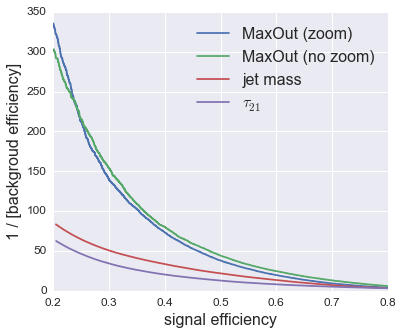

In [43]:
utils.plot_roc_curves([roc_shrink, roc_noshrink, roc_mass, roc_tau_21],
                      ['MaxOut (zoom)', 'MaxOut (no zoom)', 'jet mass', r'$\tau_{21}$'],
                      filename='plots/var_roc_comp.png')

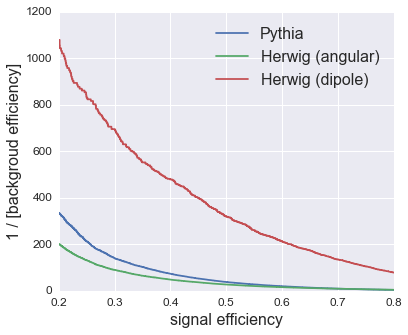

In [42]:
utils.plot_roc_curves([roc_shrink, roc_ha, roc_hd],
                      ['Pythia', 'Herwig (angular)', 'Herwig (dipole)'],
                     filename='plots/gen_roc_comp.pdf')